<a href="https://colab.research.google.com/github/kasparmartens/NeuralDecomposition/blob/master/toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade git+https://github.com/kasparmartens/NeuralDecomposition.git

  Cloning https://github.com/kasparmartens/NeuralDecomposition.git to /private/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/pip-req-build-5h3s0ev1
  Running command git clone --filter=blob:none --quiet https://github.com/kasparmartens/NeuralDecomposition.git /private/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/pip-req-build-5h3s0ev1
  Resolved https://github.com/kasparmartens/NeuralDecomposition.git to commit 42a2a6355ffe8b0a136d72975fbcdab171ac999e
  Preparing metadata (setup.py) ... done
  Created wheel for NeuralDecomposition: filename=NeuralDecomposition-0.1-py3-none-any.whl size=11183 sha256=e7a5d851cb778746e880dd7fc656739f8a393cf2327d5f28a21c88c8ba05d2ee
  Stored in directory: /private/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/pip-ephem-wheel-cache-bksgtrjs/wheels/9d/bd/a1/7250d2e9b505a29133865eeb8e595ff57b68aa404749181448
Successfully built NeuralDecomposition


Necessary imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from ND.encoder import cEncoder
from ND.decoder import Decoder
from ND.CVAE import CVAE
from ND.helpers import expand_grid

from torch.utils.data import TensorDataset, DataLoader

from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

Choose device (i.e. CPU or GPU)

In [2]:
device = "cpu"

Generate a synthetic data set (700 data points, 5 features)

In [48]:
N = 700

# generate ground truth latent variable z and covariate c
z = Uniform(-2.0, 2.0).sample((N, 1))
c = Uniform(-2.0, 2.0).sample((N, 1))
noise_sd = 0.05

# generate five features
y1 = torch.exp(-z**2) - 0.2*c
y2 = torch.sin(z) + 0.2*c + 0.7*torch.sin(z)*(z > 0).float()*c
y3 = torch.tanh(z) + 0.2*c
y4 = 0.2*z + torch.tanh(c)
y5 = 0.1*z

Y = torch.cat([y1, y2, y3, y4, y5], dim=1)
Y += noise_sd * torch.randn_like(Y)

Y = (Y - Y.mean(axis=0, keepdim=True)) / Y.std(axis=0, keepdim=True)

data_dim = Y.shape[1]
n_covariates = 1
hidden_dim = 32

For model fitting, we will need a `DataLoader` object

In [49]:
dataset = TensorDataset(Y.to(device), c.to(device))
data_loader = DataLoader(dataset, shuffle=True, batch_size=64)

Setting up the CVAE encoder + decoder

In [50]:
### ENCODER

# define encoder which maps (data, covariate) -> (z_mu, z_sigma)
encoder_mapping = nn.Sequential(
    nn.Linear(data_dim + n_covariates, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 2)
)

encoder = cEncoder(z_dim=1, mapping=encoder_mapping)

In [51]:
### DECOMPOSABLE DECODER

# grid needed for quadrature
grid_z = torch.linspace(-2.0, 2.0, steps=15).reshape(-1, 1).to(device)
grid_c = torch.linspace(-2.0, 2.0, steps=15).reshape(-1, 1).to(device)
grid_cz = torch.cat(expand_grid(grid_z, grid_c), dim=1).to(device)

decoder_z = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_c = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_cz = nn.Sequential(
    nn.Linear(2, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder = Decoder(data_dim, 
                  grid_z, grid_c, grid_cz, 
                  decoder_z, decoder_c, decoder_cz,
                  has_feature_level_sparsity=True, p1=0.1, p2=0.1, p3=0.1, 
                  lambda0=1e2, penalty_type="MDMM",
                  device=device)

Combine the encoder + decoder and fit the decomposable CVAE

In [52]:
model = CVAE(encoder, decoder, lr=5e-3, device=device)

loss, integrals = model.optimize(data_loader,
                                 n_iter=15000, 
                                 augmented_lagrangian_lr=0.1)


Fitting Neural Decomposition.
	Data set size 700. # iterations = 15000 (i.e. # epochs <= 1364)

	Iter     0.	Total loss 2064.990
	Iter   500.	Total loss 128.758
	Iter  1000.	Total loss 108.665
	Iter  1500.	Total loss 126.314
	Iter  2000.	Total loss 118.681
	Iter  2500.	Total loss 103.070
	Iter  3000.	Total loss 85.221
	Iter  3500.	Total loss 49.108
	Iter  4000.	Total loss 12.629
	Iter  4500.	Total loss 89.063
	Iter  5000.	Total loss 66.939
	Iter  5500.	Total loss 2.230
	Iter  6000.	Total loss -4.468
	Iter  6500.	Total loss -20.423
	Iter  7000.	Total loss -22.380
	Iter  7500.	Total loss -50.567
	Iter  8000.	Total loss -52.865
	Iter  8500.	Total loss -48.666
	Iter  9000.	Total loss -72.569
	Iter  9500.	Total loss -0.347
	Iter 10000.	Total loss -43.885
	Iter 10500.	Total loss -72.679
	Iter 11000.	Total loss -53.651
	Iter 11500.	Total loss -62.000
	Iter 12000.	Total loss -40.422
	Iter 12500.	Total loss -64.008
	Iter 13000.	Total loss -48.828
	Iter 13500.	Total loss -52.212
	Iter 14000.	Tot

### Diagnostics and interpretation of the model fit

First let's see if the integrals have converged sufficiently close to zero

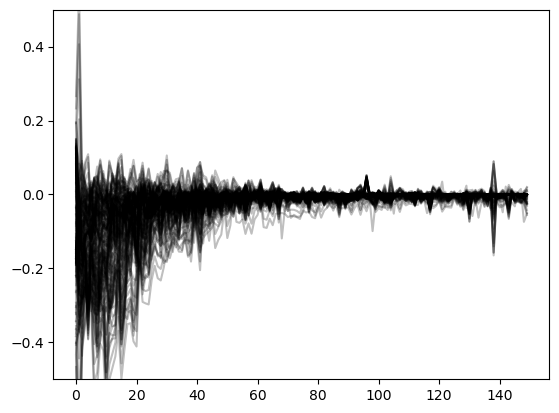

In [53]:
def plot_integrals(integrals):
    n_rep = integrals.shape[0]
    n_iter = integrals.shape[1]
    time = np.arange(n_iter).reshape(-1, 1)
    time_mat = np.tile(time, [1, n_rep])

    plt.plot(time_mat, integrals.T, c="black", alpha=0.25)
    plt.ylim(-0.5, 0.5)

plot_integrals(integrals)

Now let's look at the inferred $z$ values, together with the mappings $z \mapsto \text{features}$

In [54]:
with torch.no_grad():
    # encoding of the entire observed data set
    mu_z, sigma_z = encoder(Y.to(device), c.to(device))
    # predictions from the decoder
    Y_pred = decoder(mu_z, c.to(device))
    Y_error = Y - Y_pred

    # output to CPU
    mu_z, sigma_z = mu_z.cpu(), sigma_z.cpu()
    Y_pred = Y_pred.cpu()
    Y_error = Y_error.cpu()

### Correlation between the ground truth $z$ and the inferred $z$ values

In [55]:
np.cov(Y_pred[:, 0], Y_error[:, 0])

array([[0.98666997, 0.00300468],
       [0.00300468, 0.0073206 ]])

In [56]:
Y_error.var(dim=0, keepdim=True), Y_pred.var(dim=0, keepdim=True), mu_z.shape

(tensor([[0.0073, 0.0025, 0.0045, 0.0055, 0.1447]]),
 tensor([[0.9867, 1.0114, 1.0449, 1.0248, 0.8861]]),
 torch.Size([700, 1]))

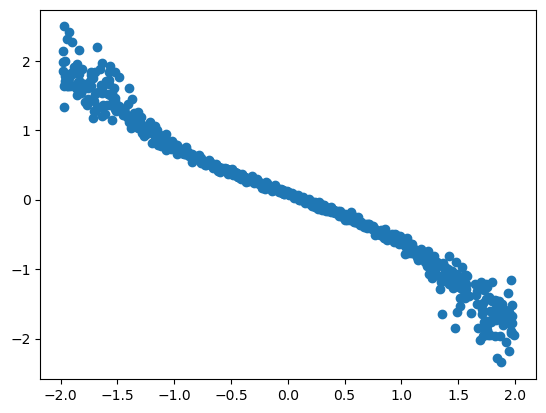

In [57]:
plt.scatter(z, mu_z)

### Visualising mappings from z to feature space

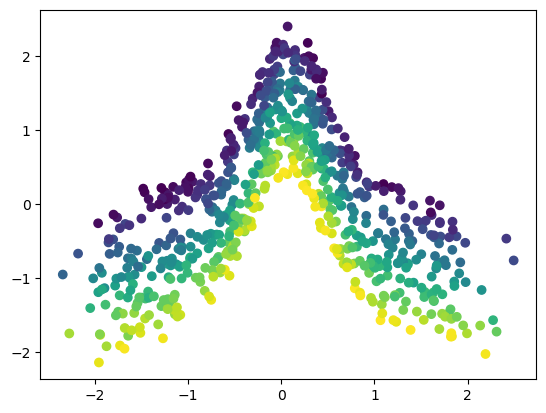

In [58]:
plt.scatter(mu_z, Y[:, 0], c=c.reshape(-1))

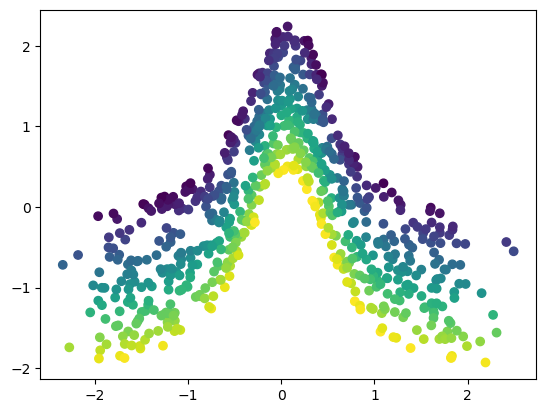

In [59]:
plt.scatter(mu_z, Y_pred[:, 0], c=c.reshape(-1))

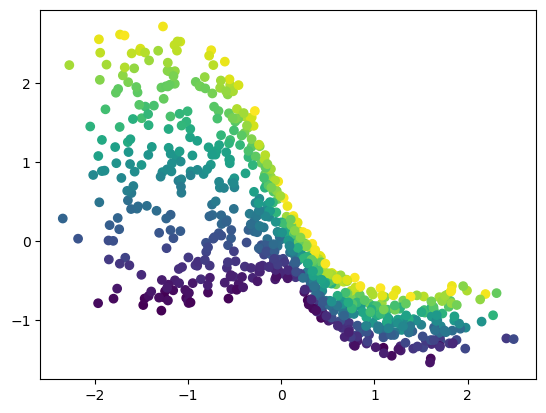

In [60]:
plt.scatter(mu_z, Y[:, 1], c=c.reshape(-1))

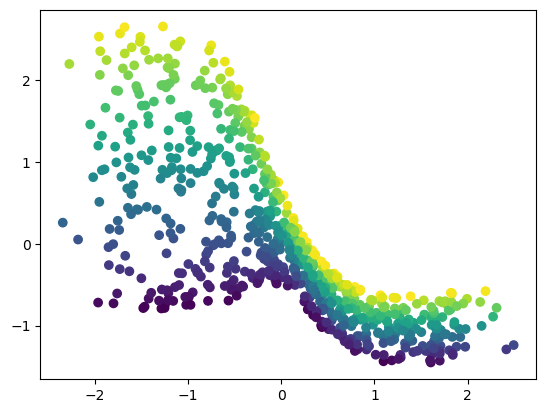

In [61]:
plt.scatter(mu_z, Y_pred[:, 1], c=c.reshape(-1))

### Inferred sparsity masks

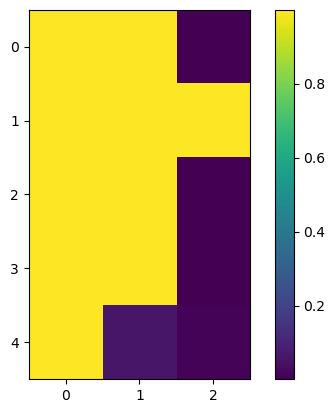

In [62]:
with torch.no_grad():
    sparsity = decoder.get_feature_level_sparsity_probs().cpu()
    
plt.imshow(sparsity)
plt.colorbar()

In [63]:
a_no_error = decoder.fraction_of_variance_explained(mu_z, c)

In [64]:
a_error = decoder.fraction_of_variance_explained(mu_z, c, Y_error=Y_error)

In [28]:
[f'{s:.2}' for s in a_no_error[0]], [f'{s:.2}' for s in a_error[0]], [f'{s/sum(a_error[0][:3]):.2}' for s in a_error[0][:3]]

(['0.72', '0.28', '7.1e-29'],
 ['0.63', '0.25', '3.4e-32', '0.12'],
 ['0.72', '0.28', '3.9e-32'])

In [47]:
[f'{s:.2}' for s in a_no_error[0]], [f'{s:.2}' for s in a_error[0]], [f'{s/sum(a_error[0][:3]):.2}' for s in a_error[0][:3]]

(['0.04', '0.96', '8.8e-18'],
 ['2.3e-17', '0.13', '1.2e-07', '0.87'],
 ['1.7e-16', '1.0', '9e-07'])

In [65]:
[f'{s:.2}' for s in a_no_error[0]], [f'{s:.2}' for s in a_error[0]], [f'{s/sum(a_error[0][:3]):.2}' for s in a_error[0][:3]]

(['0.71', '0.29', '1.5e-35'],
 ['0.7', '0.29', '2e-39', '0.0072'],
 ['0.71', '0.29', '2e-39'])

In [66]:
[f'{s:.2}' for s in a_no_error[-1]], [f'{s:.2}' for s in a_error[-1]], [f'{s/sum(a_error[-1][:3]):.2}' for s in a_error[-1][:3]]

(['1.0', '9.6e-09', '1.2e-19'],
 ['0.86', '2.7e-21', '3.2e-12', '0.14'],
 ['1.0', '3.1e-21', '3.7e-12'])

# Trying on MATRIX data

In [236]:
!pip install scipy

  Using cached scipy-1.14.1-cp310-cp310-macosx_14_0_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp310-cp310-macosx_14_0_x86_64.whl (25.5 MB)


In [67]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import os
from openpyxl import load_workbook  # To read Excel file

# CLR Transformation
def clr_transform(df):
    # Ensure there are no zeros in the data
    df = df.replace(0, np.nan).fillna(1e-04)
    
    def generalized_log_transform(x, constant=1):
        return np.log(x + np.sqrt(x**2 + constant**2))
    
    # Apply generalized log transform
    glr_df = df.apply(generalized_log_transform, axis=1)
    
    # Apply CLR transformation
    clr_df = df.apply(lambda row: np.log(row) - np.mean(np.log(row)), axis=1)
    
    return pd.DataFrame(clr_df), pd.DataFrame(glr_df)

# Median Normalization
def median_normalization(block):
    medians = block.median(axis=0, skipna=True)
    normalized_df = block.divide(medians, axis=1)
    return normalized_df

# Square Root Transformation
def sqrt_transform(block):
    return block.applymap(np.sqrt)

# Pareto Scaling
def pareto_scale(x):
    return (x - np.mean(x)) / np.sqrt(np.std(x))

# Block Scaling by Variance
def block_scale_by_variance(block):
    return block / np.sqrt(block.var(axis=0, skipna=True).sum())

# Process Block
def process_block(df):
    # df = df.apply(pd.to_numeric, errors='coerce')  # Convert all values to numeric
    df = df.apply(pareto_scale, axis=0)  # Apply Pareto scaling
    # df = block_scale_by_variance(df)  # Scale by variance
    return df

# File Path
file_path = "~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx"

# Read all sheet names
sheet_names = pd.ExcelFile(file_path).sheet_names

results = {}

# Process each sheet
for sheet in sheet_names:
    if sheet != "Factors":
        data = pd.read_excel(file_path, sheet_name=sheet)
        if sheet == "OTUs":
            clr_df, glr_df = clr_transform(data)
            results[sheet] = process_block(clr_df)
        else:
            data = median_normalization(data)
            # data = sqrt_transform(data)
            results[sheet] = process_block(pd.DataFrame(data))

# Combine results into a single matrix
result_matrix = pd.concat(results.values(), axis=1)

# Save the result to a new Excel file if needed
# output_file = "processed_results.xlsx"
# result_matrix.to_excel(output_file, index=False)


In [68]:
from ND.decoder_multiple_covariates import Decoder_multiple_covariates
from ND.CVAE_multiple_covariates import CVAE_multiple_covariates

In [69]:
df_factors = pd.read_excel("~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx", sheet_name='LIP_TS_NEG')
df_factors_otu = pd.read_excel("~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx", sheet_name='OTUs')

In [70]:
df_cov = pd.read_excel("~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx", sheet_name='Factors')

In [71]:
# result_matrix = result_matrix[[c for c in list(df_factors.columns) + list(df_factors_otu.columns)]]

In [72]:
# Y = df_factors.to_numpy()
# row_sums = Y.sum(axis=1, keepdims=True)
# Y = Y / row_sums

# Y = generalized_log_transform(Y, a=1)

In [73]:
Y = result_matrix.to_numpy()
Y = torch.Tensor(Y)

In [74]:
c = torch.Tensor([pd.factorize(df_cov[c])[0] for c in df_cov.columns[2:]]).T

/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_80107/2497541583.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_290u7eqnqq/croot/pytorch-select_1730848721858/work/torch/csrc/utils/tensor_new.cpp:277.)
  c = torch.Tensor([pd.factorize(df_cov[c])[0] for c in df_cov.columns[2:]]).T


In [75]:
time = pd.factorize(df_cov['Time'])[0]

In [76]:
c.shape, Y.shape

(torch.Size([82, 2]), torch.Size([82, 8118]))

In [77]:
# Y = torch.Tensor(Y)[:, np.random.randint(Y.shape[1], size=(100,))]

In [78]:
# Y.shape

In [79]:
data_dim = Y.shape[1]
n_covariates = c.shape[1]
hidden_dim = 128
z_dim = 1

In [80]:
dataset = TensorDataset(Y.to(device), c.to(device))
data_loader = DataLoader(dataset, shuffle=True, batch_size=64)

In [81]:
### ENCODER

# define encoder which maps (data, covariate) -> (z_mu, z_sigma)
encoder_mapping = nn.Sequential(
    nn.Linear(data_dim + n_covariates, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 2*z_dim)
)

encoder = cEncoder(z_dim=z_dim, mapping=encoder_mapping)

In [82]:
### DECOMPOSABLE DECODER

lim_val = 2.0
steps = 15
# grid needed for quadrature
grid_z = torch.linspace(-lim_val, lim_val, steps=steps).reshape(-1, 1).to(device)
# grid_z = torch.cat(expand_grid(grid_z, grid_z), dim=1).to(device)
grid_cov = torch.linspace(-lim_val, lim_val, steps=steps).reshape(-1, 1).to(device)
grid_c = [grid_cov for _ in range(n_covariates)]
# grid_cz = [torch.cat(expand_grid(grid_z, gr), dim=1).to(device) for gr in grid_c]

decoder_z = nn.Sequential(
    nn.Linear(z_dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_c = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_cz = nn.Sequential(
    nn.Linear(1 + z_dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder = Decoder_multiple_covariates(data_dim, n_covariates,
                  grid_z, grid_c, 
                  decoder_z, [decoder_c for _ in range(n_covariates)], [decoder_cz for _ in range(n_covariates)],
                  has_feature_level_sparsity=True, p1=0.1, p2=0.1, p3=0.1, 
                  lambda0=1e2, penalty_type="MDMM",
                  device=device)

In [84]:
encoder, decoder

(cEncoder(
   (mapping): Sequential(
     (0): Linear(in_features=8120, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=2, bias=True)
   )
 ),
 Decoder_multiple_covariates(
   (mapping_z): Sequential(
     (0): Linear(in_features=1, out_features=128, bias=True)
     (1): Tanh()
     (2): Linear(in_features=128, out_features=8118, bias=True)
   )
 ))

In [85]:
model = CVAE_multiple_covariates(encoder, decoder, lr=5e-4, device=device)

loss, integrals = model.optimize(data_loader,
                                 n_iter=5000, 
                                 augmented_lagrangian_lr=0.1)


Fitting Neural Decomposition.
	Data set size 82. # iterations = 5000 (i.e. # epochs <= 2500)

	Iter     0.	Total loss 4793196.000
	Iter   500.	Total loss 1714176.875
	Iter  1000.	Total loss 1320029.875
	Iter  1500.	Total loss 1130364.500
	Iter  2000.	Total loss 929322.125
	Iter  2500.	Total loss 794557.125
	Iter  3000.	Total loss 703036.938
	Iter  3500.	Total loss 665185.312
	Iter  4000.	Total loss 646169.250
	Iter  4500.	Total loss 613668.500


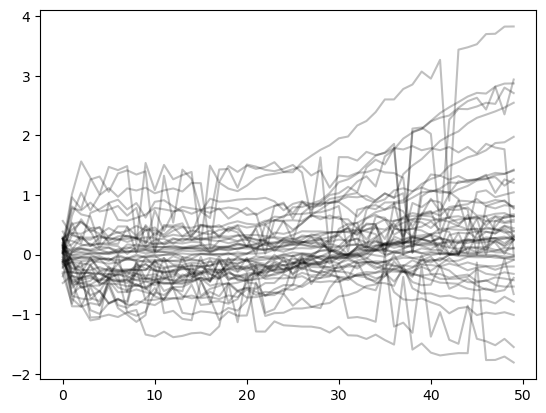

In [86]:
def plot_integrals(integrals):
    n_rep = integrals.shape[0]
    n_iter = integrals.shape[1]
    time = np.arange(n_iter).reshape(-1, 1)
    time_mat = np.tile(time, [1, n_rep])

    plt.plot(time_mat, integrals.T, c="black", alpha=0.25)

plot_integrals(integrals[:50])

In [87]:
with torch.no_grad():
    # encoding of the entire observed data set
    mu_z, sigma_z = encoder(Y.to(device), c.to(device))
    # predictions from the decoder
    Y_pred = decoder(mu_z, c.to(device))
    Y_error = Y - Y_pred

    # output to CPU
    mu_z, sigma_z = mu_z.cpu(), sigma_z.cpu()
    Y_pred = Y_pred.cpu()
    Y_error = Y_error.cpu()

In [97]:
varexp = decoder.fraction_of_variance_explained(mu_z, c, Y_error=Y_error)

In [98]:
varexp.shape

torch.Size([8118, 4])

In [107]:
varexp[7926]

tensor([8.1715e-01, 3.7219e-05, 1.3764e-01, 4.5174e-02])

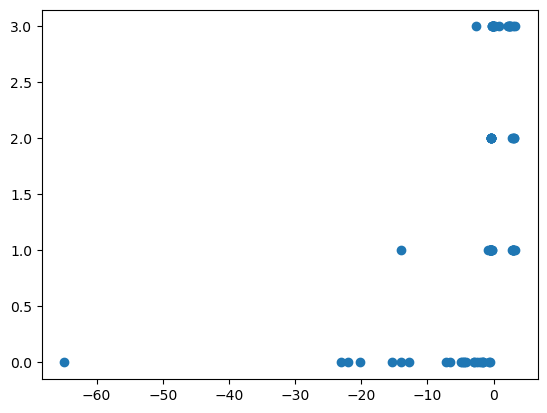

In [109]:
plt.scatter(mu_z, time)
# plt.xlim((-10, 10))
plt.show()

In [110]:
varexp.sum(axis=1).mean()

tensor(1.)

In [111]:
varexp[:, 0].mean(), varexp[:, 1].mean(), varexp[:, 2].mean()

(tensor(0.4480), tensor(0.0404), tensor(0.2003))

In [112]:
(varexp[:, 2] > 0.8).nonzero().T

tensor([[ 131, 1804, 1995, 2365, 2614, 2635, 3437, 3580, 5506, 6140]])

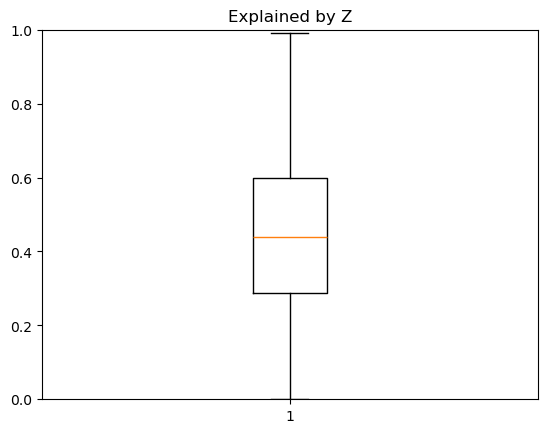

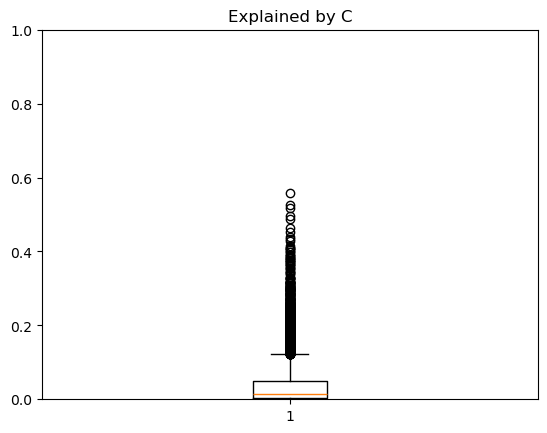

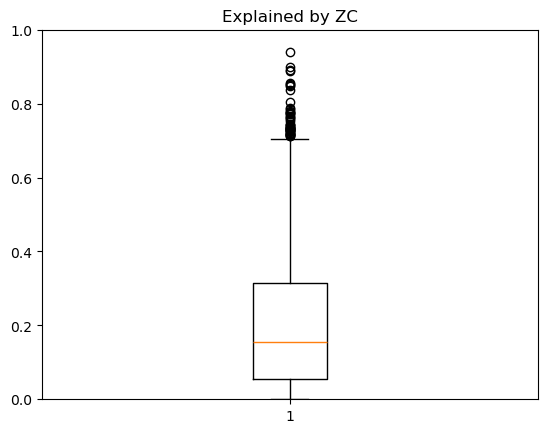

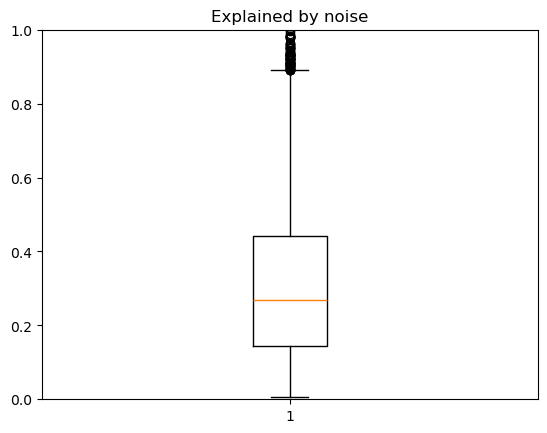

In [115]:
plt.boxplot(varexp[:, 0])
plt.title('Explained by Z')
plt.ylim((0, 1))
plt.show()
plt.boxplot(varexp[:, 1])
plt.title('Explained by C')
plt.ylim((0, 1))
plt.show()
plt.boxplot(varexp[:, 2])
plt.title('Explained by ZC')
plt.ylim((0, 1))
plt.show()
plt.boxplot(varexp[:, 3])
plt.title('Explained by noise')
plt.ylim((0, 1))
plt.show()

In [979]:
{0: 140722, 1: 280622, 2: 160622, 3: 210622}

{0: 140722, 1: 280622, 2: 160622, 3: 210622}

1045 tensor([0.6679, 0.0098, 0.0102, 0.3121]) tensor(1.)


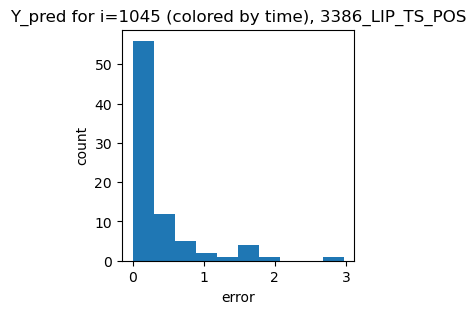

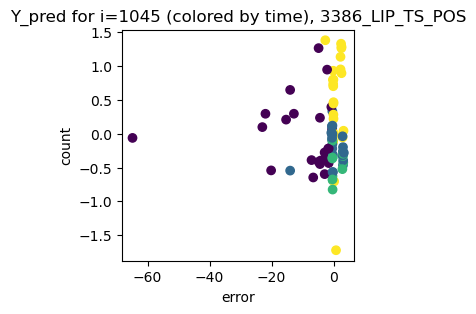

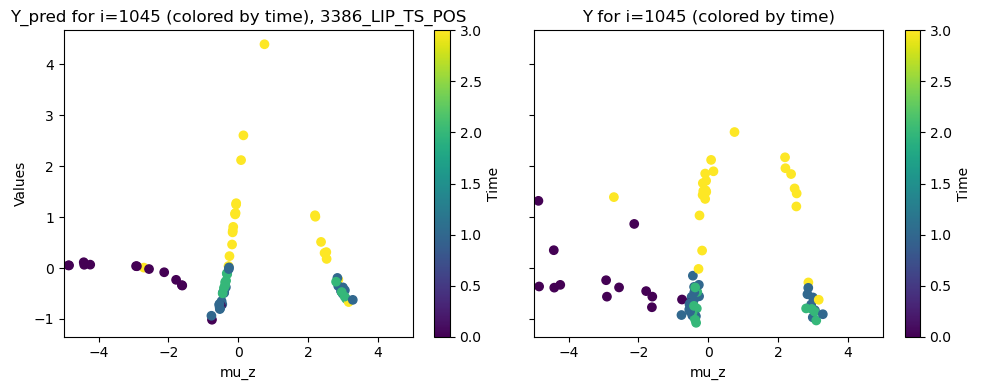

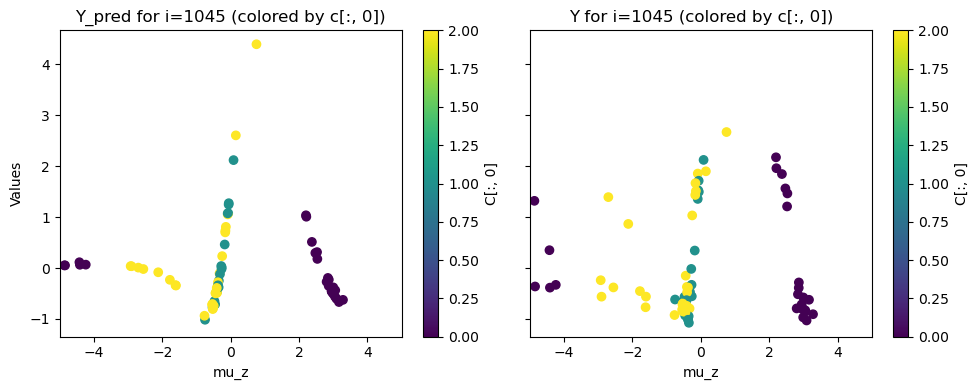

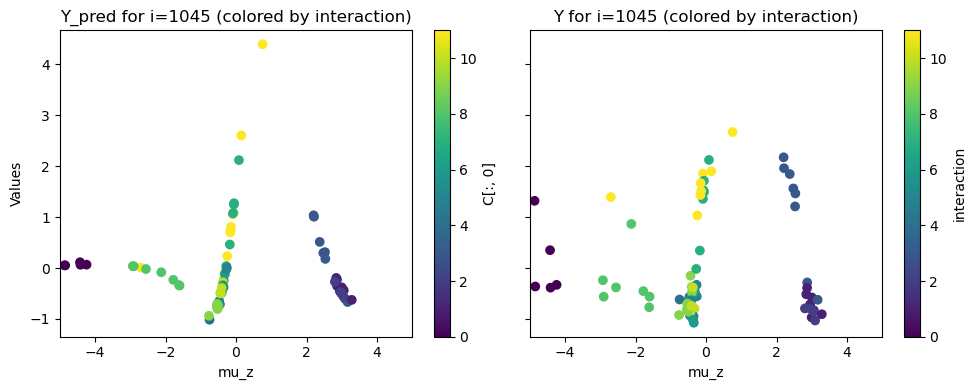

1158 tensor([0.5541, 0.0278, 0.2126, 0.2055]) tensor(1.)


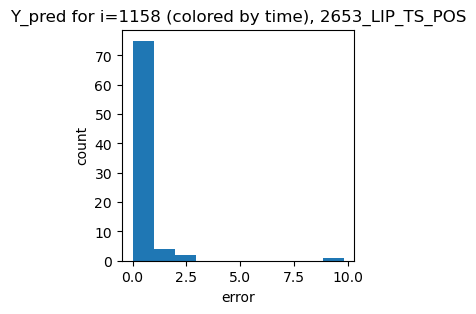

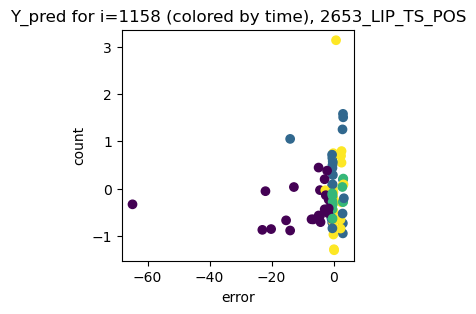

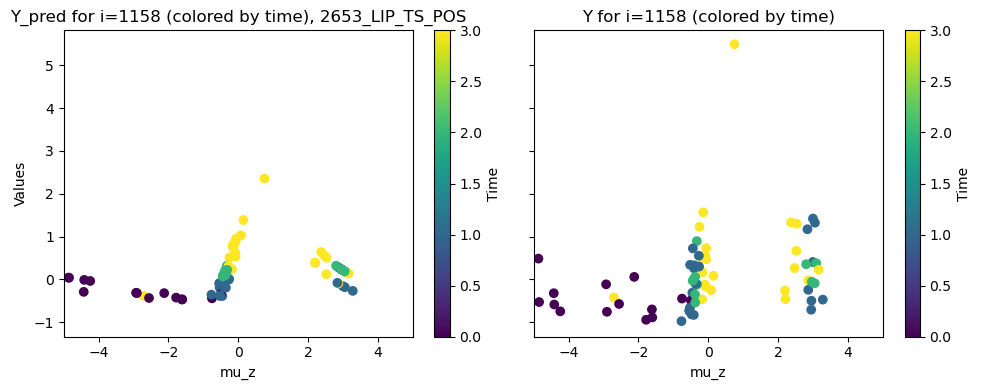

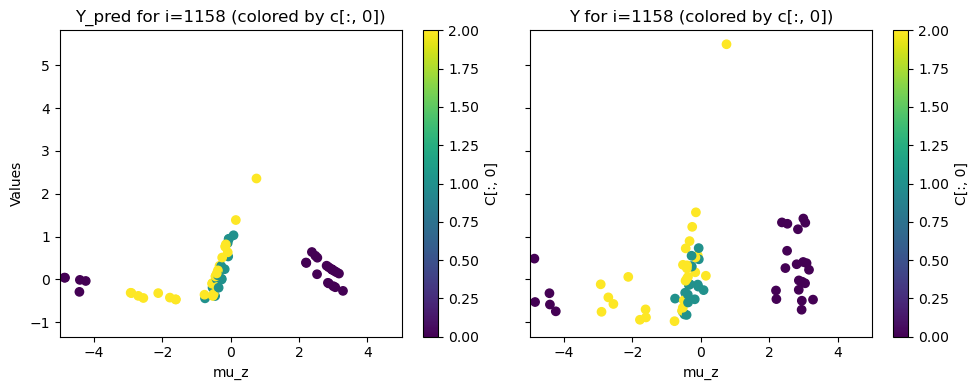

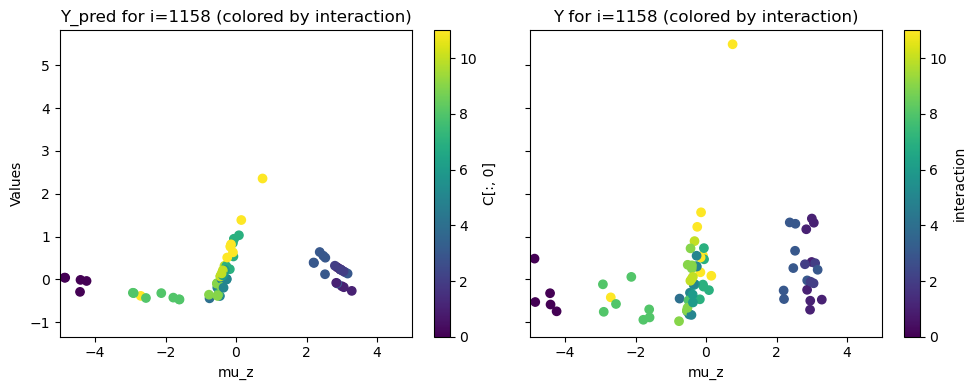

1232 tensor([0.4929, 0.0262, 0.0304, 0.4506]) tensor(1.)


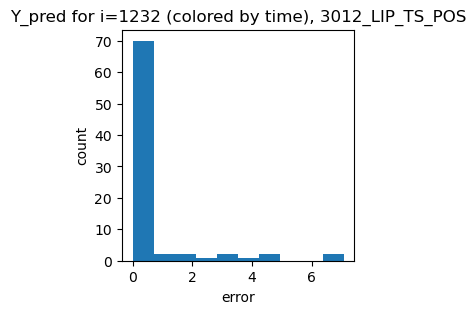

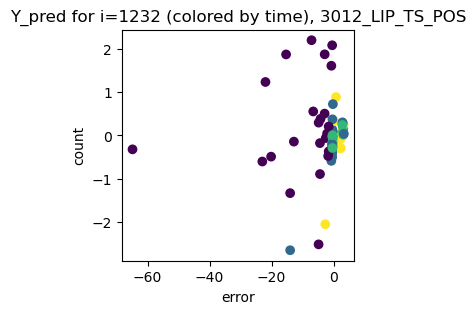

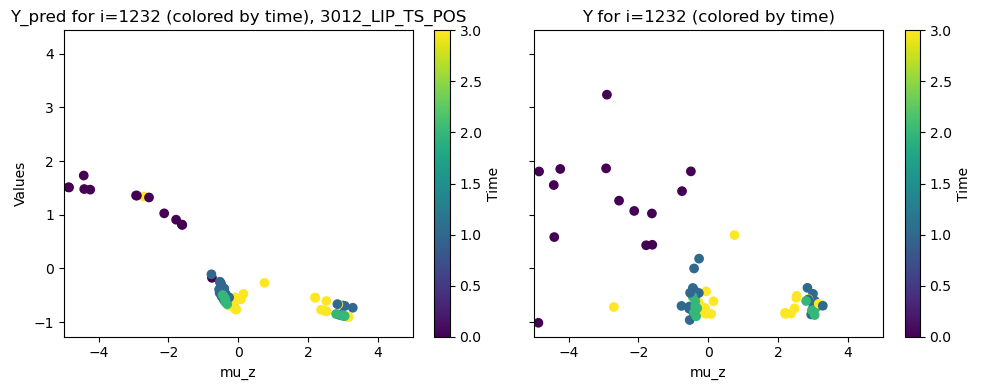

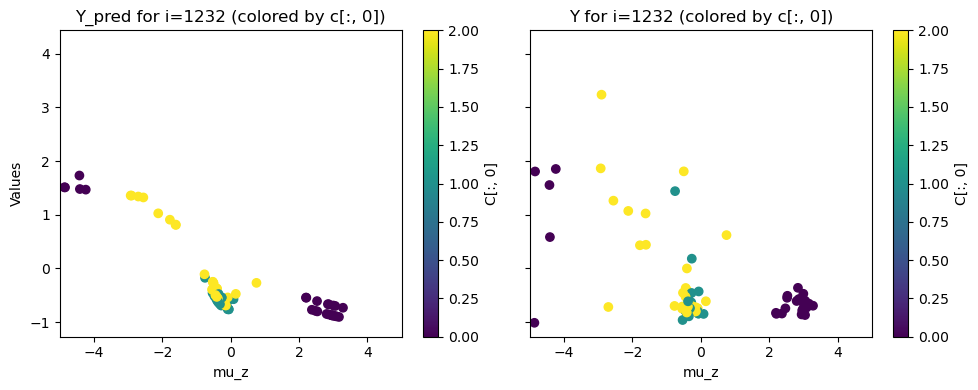

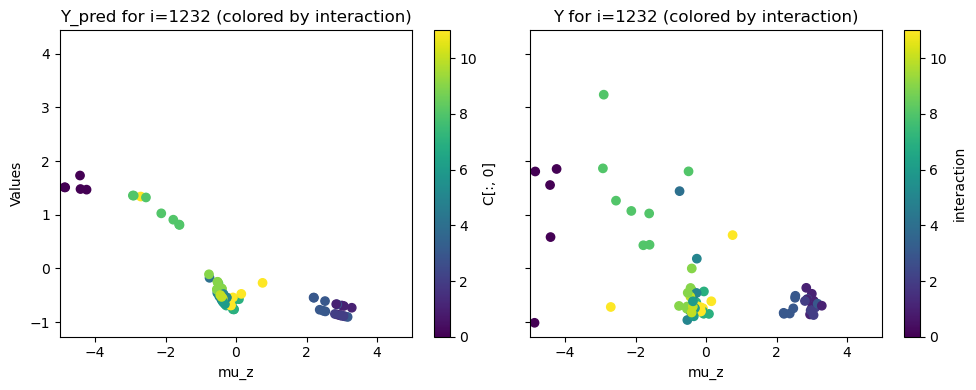

In [114]:
import matplotlib.pyplot as plt

lims = [-5, 5]

for i in [1045, 1158, 1232]:
    print(i, varexp[i], varexp[i].sum())
    size = (10, 4)

    fig, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True, sharex=True)  # Two subplots side by side
    sc1 = axes.hist((Y[:, i] - Y_pred[:, i])**2)
    axes.set_title(f"Y_pred for i={i} (colored by time), {result_matrix.columns[i]}")
    axes.set_xlabel("error")
    axes.set_ylabel("count")

    fig, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True, sharex=True)  # Two subplots side by side
    sc1 = axes.scatter(mu_z, (Y[:, i] - Y_pred[:, i]), c=time.reshape(-1))
    axes.set_title(f"Y_pred for i={i} (colored by time), {result_matrix.columns[i]}")
    axes.set_xlabel("error")
    axes.set_ylabel("count")
    
    fig, axes = plt.subplots(1, 2, figsize=size, sharey=True, sharex=True)  # Two subplots side by side
    axes[0].set_xlim(lims)
    
    # First subplot: Y_pred
    sc1 = axes[0].scatter(mu_z, Y_pred[:, i], c=time.reshape(-1))
    axes[0].set_title(f"Y_pred for i={i} (colored by time), {result_matrix.columns[i]}")
    axes[0].set_xlabel("mu_z")
    axes[0].set_ylabel("Values")
    fig.colorbar(sc1, ax=axes[0], label='Time')
    
    # Second subplot: Y
    sc2 = axes[1].scatter(mu_z, Y[:, i], c=time.reshape(-1))
    axes[1].set_title(f"Y for i={i} (colored by time)")
    axes[1].set_xlabel("mu_z")
    fig.colorbar(sc2, ax=axes[1], label='Time')
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=size, sharey=True, sharex=True)  # Two subplots side by side
    axes[0].set_xlim(lims)

    # First subplot: Y_pred
    sc3 = axes[0].scatter(mu_z, Y_pred[:, i], c=c[:, 0].reshape(-1))
    axes[0].set_title(f"Y_pred for i={i} (colored by c[:, 0])")
    axes[0].set_xlabel("mu_z")
    axes[0].set_ylabel("Values")
    fig.colorbar(sc3, ax=axes[0], label='C[:, 0]')
    
    # Second subplot: Y
    sc4 = axes[1].scatter(mu_z, Y[:, i], c=c[:, 0].reshape(-1))
    axes[1].set_title(f"Y for i={i} (colored by c[:, 0])")
    axes[1].set_xlabel("mu_z")
    fig.colorbar(sc4, ax=axes[1], label='C[:, 0]')
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=size, sharey=True, sharex=True)  # Two subplots side by side
    axes[0].set_xlim(lims)
    
    # Second subplot: Y
    c_0 = list(map(str, c[:, 0].reshape(-1).detach().numpy()))
    t = list(map(str, time.reshape(-1)))
    interact = np.array([i + j for i, j in zip(c_0, t)])
    interact = np.unique(interact, return_inverse=True)[1]
    
    # First subplot: Y_pred
    sc3 = axes[0].scatter(mu_z, Y_pred[:, i], c=interact)
    axes[0].set_title(f"Y_pred for i={i} (colored by interaction)")
    axes[0].set_xlabel("mu_z")
    axes[0].set_ylabel("Values")
    fig.colorbar(sc3, ax=axes[0], label='C[:, 0]')

    sc4 = axes[1].scatter(mu_z, Y[:, i], c=interact)
    axes[1].set_title(f"Y for i={i} (colored by interaction)")
    axes[1].set_xlabel("mu_z")
    fig.colorbar(sc4, ax=axes[1], label='interaction')
    
    plt.tight_layout()
    plt.show()




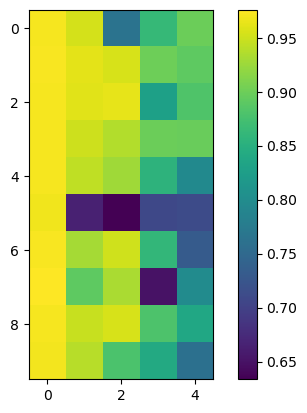

In [95]:
with torch.no_grad():
    sparsity = decoder.get_feature_level_sparsity_probs().cpu()

# plt.figure(figsize=(10, 40))
plt.imshow(sparsity[:10])
plt.colorbar()